<h1><center> Data Preparation - Data Preparation phase Notebook  </center></h1>

In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.stats import kstest

In [51]:
# Data Insertion
df = pd.read_csv(r'../../telco_customers.csv')

### Data Cleaning

##### Initial data preparation

In [52]:
# Capitalize all columns for consistency
df.rename(columns = lambda x: "".join([w[0].upper() + w[1:] for w in x.split()]), inplace = True)

# Drop CustomerID, as it holds no bearing on the future predictions
df = df.drop("CustomerID", axis=1)

df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

numerical_features = ['Tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features = df.columns.difference(numerical_features)

# Set column data type
df[numerical_features] = df[numerical_features].apply(pd.to_numeric, errors='coerce')

df.dtypes

Gender               object
SeniorCitizen        object
Partner              object
Dependents           object
Tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

##### Missing Value Analysis

In [53]:
# Get all columns that hold null values
df.columns[df.isnull().sum() != 0].tolist()

['TotalCharges']

In [54]:
# Replace the null values with 0 (it is a result of customers with 1 month tenure)
df["TotalCharges"] = df["TotalCharges"].fillna(0)
df["TotalCharges"].isnull().sum()

0

##### Outlier Analysis

Identifying Outliers using the IQR Method:

In [334]:
for feature in numerical_features:
    copy_df = df.copy()
    copy_df[feature] = sorted(copy_df[feature])
    Q1, Q3 = np.percentile(copy_df[feature], [25, 75])
    IQR = Q3 - Q1
    lower_bound = Q1 - (1.5 * IQR) 
    upper_bound = Q3 + (1.5 * IQR) 
    out = copy_df[(copy_df[feature] < lower_bound) | (copy_df[feature] > upper_bound)]
    print(f"The column '{feature}' has {out.shape[0]} outliers!")
del copy_df

The column 'Tenure' has 0 outliers!
The column 'MonthlyCharges' has 0 outliers!
The column 'TotalCharges' has 0 outliers!


Identifying Outliers using the Z-Score Method:

In [335]:
for feature in numerical_features:
    copy_df = df.copy()
    mean = np.mean(copy_df[feature])
    std = np.std(copy_df[feature])
    copy_df["charges_z_score"] = (copy_df[feature] - mean) / std

    # create empty list
    outlier_indexes = []

    # add index numbers of outliers to list
    outlier_indexes.extend(copy_df.index[copy_df['charges_z_score'] > 3].tolist())
    outlier_indexes.extend(copy_df.index[copy_df['charges_z_score'] < -3].tolist())

    new_data = copy_df.drop(copy_df.index[outlier_indexes])
    
    print(f"The column '{feature}' has {df.shape[0] - new_data.shape[0]} outliers!")
del copy_df

The column 'Tenure' has 0 outliers!
The column 'MonthlyCharges' has 0 outliers!
The column 'TotalCharges' has 0 outliers!


##### Label Encoding

In [55]:
# Encoding
features_to_one_hot_encode = [feature for feature in categorical_features if df[feature].nunique() > 2]
features_to_label_encode = [feature for feature in categorical_features if df[feature].nunique() == 2]

one_hot_df = pd.get_dummies(df[features_to_one_hot_encode])
one_hot_df.columns = one_hot_df.columns.str.replace(' ', '_')

# Label encode the specified columns
label_encode_df = df[features_to_label_encode].apply(LabelEncoder().fit_transform)

# Combine the encoded dataframes
df_enc = pd.concat([df.drop(columns=features_to_one_hot_encode+features_to_label_encode), one_hot_df, label_encode_df], axis=1)

df_enc.columns

Index(['Tenure', 'MonthlyCharges', 'TotalCharges', 'Contract_Month-to-month',
       'Contract_One_year', 'Contract_Two_year', 'DeviceProtection_No',
       'DeviceProtection_No_internet_service', 'DeviceProtection_Yes',
       'InternetService_DSL', 'InternetService_Fiber_optic',
       'InternetService_No', 'MultipleLines_No',
       'MultipleLines_No_phone_service', 'MultipleLines_Yes',
       'OnlineBackup_No', 'OnlineBackup_No_internet_service',
       'OnlineBackup_Yes', 'OnlineSecurity_No',
       'OnlineSecurity_No_internet_service', 'OnlineSecurity_Yes',
       'PaymentMethod_Bank_transfer_(automatic)',
       'PaymentMethod_Credit_card_(automatic)',
       'PaymentMethod_Electronic_check', 'PaymentMethod_Mailed_check',
       'StreamingMovies_No', 'StreamingMovies_No_internet_service',
       'StreamingMovies_Yes', 'StreamingTV_No',
       'StreamingTV_No_internet_service', 'StreamingTV_Yes', 'TechSupport_No',
       'TechSupport_No_internet_service', 'TechSupport_Yes', 'Chur

In [56]:
del df_enc["TotalCharges"]
del df_enc["MultipleLines_No_phone_service"]
del df_enc["OnlineSecurity_No_internet_service"]
del df_enc["StreamingTV_No_internet_service"]
del df_enc["OnlineBackup_No_internet_service"]
del df_enc["DeviceProtection_No_internet_service"]
del df_enc["InternetService_No"]
del df_enc["MultipleLines_Yes"]
del df_enc["TechSupport_No_internet_service"]
del df_enc["PhoneService"]
del df_enc["MultipleLines_No"]
del df_enc["StreamingMovies_No_internet_service"]

##### Data splitting

In [57]:
X = df_enc.drop(columns=['Churn'])
y = df_enc['Churn']

# set aside 20% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2, random_state = 8)

# Use the same function above for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2

print(f"Training features shape: {X_train.shape}")
print(f"Training features shape: {X_test.shape}")
print(f"Training features shape: {X_val.shape}")

Training features shape: (4225, 28)
Training features shape: (1409, 28)
Training features shape: (1409, 28)


### Feature Scaling

In [338]:
y_train

608     0
5007    0
5329    1
3485    1
6530    0
       ..
1265    0
3229    1
3810    0
2147    0
4252    0
Name: Churn, Length: 4225, dtype: int32

Viewing the distribution of the Numerical Features

In [ ]:
# https://towardsdatascience.com/6-ways-to-test-for-a-normal-distribution-which-one-to-use-9dcf47d8fa93
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6350423/

def check_normality_ks(df):
    
    alpha=0.05
    for column in df.columns:
      column = df[column]  
      result = kstest(column, 'norm')

      if result.pvalue < alpha:
        print('The column is not normally distributed.')
      else:
        print('The column is normally distributed.')

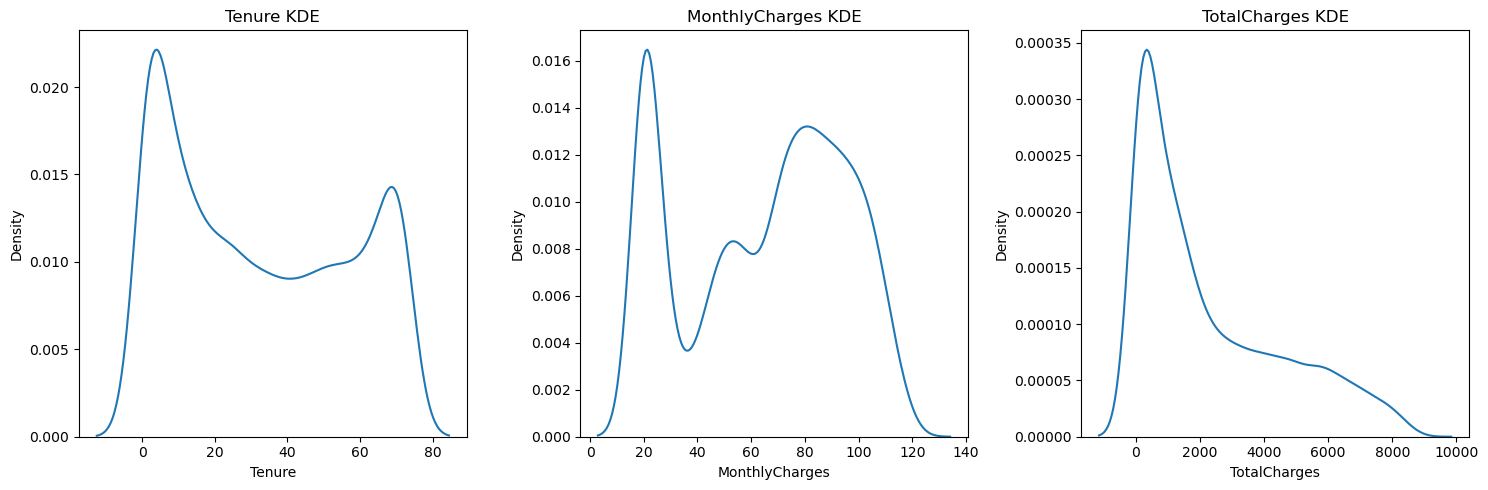

In [339]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(nrows=1, ncols=len(numerical_features), figsize=(15, 5))

for i, feature in enumerate(numerical_features):
    sns.kdeplot(df_enc[feature], ax=axs[i])
    axs[i].set_title("{} KDE".format(feature))

plt.tight_layout()
plt.show()

In [58]:
mms = MinMaxScaler() # Normalization
numerical_features = ['Tenure', 'MonthlyCharges']
# fit the scaler on the training data and transform it
X_train[numerical_features] = mms.fit_transform(X_train[numerical_features])

# transform the validation and test data using the same scaler
X_val[numerical_features] = mms.transform(X_val[numerical_features])
X_test[numerical_features] = mms.transform(X_test[numerical_features])


We have 2 options for data scaling : 
1) Normalization 
2) Standardization

Since most of the algorithms assume the data to be normally (Gaussian) distributed, Normalization is done for features whose data does not display normal distribution and standardization is carried out for features that are normally distributed where their values are huge or very small as compared to other features.

Normalization : tenure, MonthlyCharges and TotalCharges features are normalized as they displayed a right skewed and bimodal data distribution.

Standardization : None of the features are standardized for the above data. Since we don't have to, as we have normalized it already


In [11]:
import plotly.express as px

excluded = ['Tenure','MonthlyCharges','TotalCharges']
df_nr = X_train[excluded]
df_nr = X_train[excluded].assign(Churn=y_train)
corr_matrix = df_nr.corr(method='spearman') # Tenure - ordinal variable
fig = px.imshow(corr_matrix, color_continuous_scale="RdBu",text_auto=True) # Plot the correlation matrix as a heatmap
fig.update_layout(title="Spearsman Correlation: Tenure, Charges - Churn",width=500,height=400)
fig.show()
#https://anyi-guo.medium.com/correlation-pearson-vs-spearman-c15e581c12ce
# Churn: Tenure, MonthlyCharges and TotalCharges

In [21]:
from dython.nominal import associations
import matplotlib.pyplot as plt

plt.ioff() # to not show the default matplotlib plot from the associations function
excluded = ['Tenure','MonthlyCharges','TotalCharges']
string_columns = [ col for col in X_train.columns if col not in excluded]
df_categorical = X_train[string_columns].assign(Churn=y_train)
corr_measures = associations(df_categorical, nominal_columns='all', plot = False)
fig = px.imshow(corr_measures['corr'],color_continuous_scale="RdBu",text_auto=True)
fig.update_layout(title="Cramer's V Correlation Heatmap - Categorical and Churn variables", width=800, height=700)
fig.show()

In [23]:
c_matrix = corr_measures['corr']
churn_corr = c_matrix['Churn'].sort_values(ascending=False)
churn_corr[:5]

Churn                      1.000000
Contract_Month-to-month    0.409979
OnlineSecurity_No          0.348539
TechSupport_No             0.336183
Contract_Two_year          0.310557
Name: Churn, dtype: float64

In [24]:
indices = np.where((c_matrix > 0.8) & (c_matrix < 1))
correlated_pairs = [(c_matrix.index[i], c_matrix.columns[j]) for i, j in zip(*indices) if i < j]

In [25]:
unique_values = []
for pair in correlated_pairs:
    unique_values.extend(set(pair))
distinct_values = list(set(unique_values))
print(distinct_values)

['StreamingTV_No_internet_service', 'OnlineSecurity_No_internet_service', 'MultipleLines_No', 'PhoneService', 'DeviceProtection_No_internet_service', 'StreamingMovies_No_internet_service', 'MultipleLines_No_phone_service', 'InternetService_No', 'TechSupport_No_internet_service', 'MultipleLines_Yes', 'OnlineBackup_No_internet_service']


In [42]:
import plotly.express as px

excluded = ['Tenure','MonthlyCharges']
df_nr = X_train[excluded]
df_nr = X_train[excluded].assign(Churn=y_train)
corr_matrix = df_nr.corr(method='spearman') # Tenure - ordinal variable
fig = px.imshow(corr_matrix, color_continuous_scale="RdBu",text_auto=True) # Plot the correlation matrix as a heatmap
fig.update_layout(title="Spearsman Correlation: Tenure, Charges - Churn",width=500,height=400)
fig.show()
#https://anyi-guo.medium.com/correlation-pearson-vs-spearman-c15e581c12ce
# Churn: Tenure, MonthlyCharges and TotalCharges

In [43]:
from dython.nominal import associations
import matplotlib.pyplot as plt

plt.ioff() # to not show the default matplotlib plot from the associations function
excluded = ['Tenure','MonthlyCharges']
string_columns = [ col for col in X_train.columns if col not in excluded]
df_categorical = X_train[string_columns].assign(Churn=y_train)
corr_measures = associations(df_categorical, nominal_columns='all', plot = False)
fig = px.imshow(corr_measures['corr'],color_continuous_scale="RdBu",text_auto=True)
fig.update_layout(title="Cramer's V Correlation Heatmap - Categorical and Churn variables", width=800, height=700)
fig.show()

### Feature Engineering & Selection

In [45]:
# Low-Variance Feature Selection
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold = 0.1)
selector.fit(X_train)

# Get columns to keep and remove
cols_to_keep = X_train.columns[selector.get_support()]
cols_to_remove = X_train.columns[~selector.get_support()]

# Remove low-variance features from the dataset
# df_enc = df_enc[cols_to_keep]

print(f"Variables to be removed based on low-variance: {cols_to_remove}")

Variables to be removed based on low-variance: Index(['MonthlyCharges'], dtype='object')


### Data Balancing

In [46]:
print(f"Proportion of Churn values in original data-set: {(df_enc['Churn'] == 1).sum()} out of {len(df_enc['Churn'])}")
print("With Churned amount:", round((df_enc['Churn'] == 1).sum() / len(df_enc['Churn']), 3) * 100, "%")  

Proportion of Churn values in original data-set: 1869 out of 7043
With Churned amount: 26.5 %


In [59]:
from imblearn.under_sampling import RandomUnderSampler

# Apply RandomUnderSampler to balance the classes
rus = RandomUnderSampler(sampling_strategy = 1)
X_res, y_res = rus.fit_resample(X_train, y_train)

# Combine the resampled features and target into a new DataFrame
df_balanced_rus = [X_res, y_res]

In [60]:
from imblearn.over_sampling import RandomOverSampler

# Apply RandomUnderSampler to balance the classes
ros = RandomOverSampler(sampling_strategy = 1)
X_res, y_res = rus.fit_resample(X_train, y_train)

# Combine the resampled features and target into a new DataFrame
df_balanced_ros = [X_res, y_res]


In [61]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy = 1)

# Apply SMOTE to balance the classes
X_res, y_res = sm.fit_resample(X_train, y_train)

# Combine the resampled features and target into a new DataFrame
df_balanced_smote = [X_res, y_res]

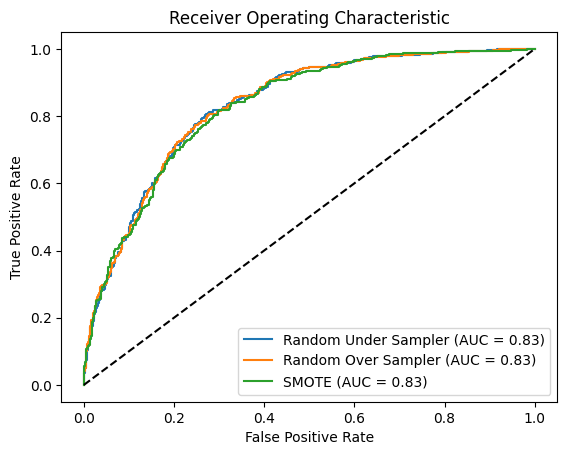

In [62]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# X_train and y_train are your training data
# instantiate LogisticRegression classifier with desired hyperparameters
clf = LogisticRegression()

# balanced_datasets is a list of balanced datasets (X_train, y_train)
# clf is your classifier object
# clf_name is the name of your classifier (for legend)
names = ["Random Under Sampler", "Random Over Sampler", "SMOTE"]
for i, data in enumerate([df_balanced_rus, df_balanced_ros, df_balanced_smote]):
    clf.fit(data[0], data[1])
    y_pred = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='%s (AUC = %0.2f)' % (names[i], roc_auc))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression - Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

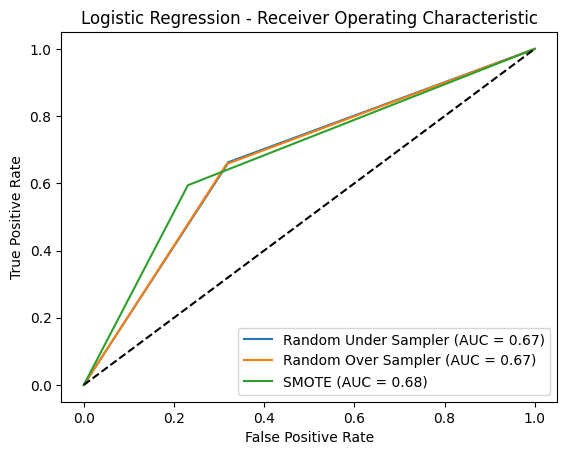

In [63]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# X_train and y_train are your training data
# instantiate LogisticRegression classifier with desired hyperparameters
clf = DecisionTreeClassifier()

# balanced_datasets is a list of balanced datasets (X_train, y_train)
# clf is your classifier object
# clf_name is the name of your classifier (for legend)
names = ["Random Under Sampler", "Random Over Sampler", "SMOTE"]
for i, data in enumerate([df_balanced_rus, df_balanced_ros, df_balanced_smote]):
    clf.fit(data[0], data[1])
    y_pred = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='%s (AUC = %0.2f)' % (names[i], roc_auc))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree - Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

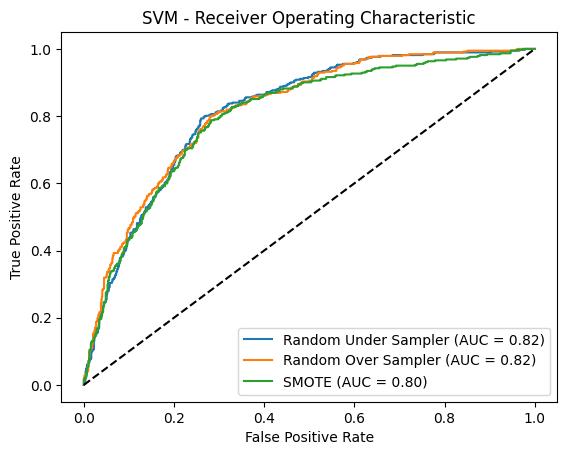

In [65]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn import svm

# X_train and y_train are your training data
# instantiate LogisticRegression classifier with desired hyperparameters
clf = svm.SVC(probability=True)

# balanced_datasets is a list of balanced datasets (X_train, y_train)
# clf is your classifier object
# clf_name is the name of your classifier (for legend)
names = ["Random Under Sampler", "Random Over Sampler", "SMOTE"]
for i, data in enumerate([df_balanced_rus, df_balanced_ros, df_balanced_smote]):
    clf.fit(data[0], data[1])
    y_pred = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='%s (AUC = %0.2f)' % (names[i], roc_auc))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM - Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [67]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

majority_class = y_train.value_counts().idxmax()
X_val['target'] = majority_class
y_true = y_val
y_pred = X_val['target']

print(f"Classification Report : \n\n{classification_report(y_val, y_pred)}")

cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
cm_df = pd.DataFrame(cm, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])

fig = px.imshow(cm_df, labels=dict(x="Predicted", y="Actual", color="Count"),
                x=['Predicted Negative', 'Predicted Positive'],
                y=['Actual Negative', 'Actual Positive'],
                color_continuous_scale=px.colors.sequential.Blues,text_auto=True)

fig.update_traces(showscale=True) 
fig.update_layout(title='Confusion Matrix - Baseline')
fig.show()

Classification Report : 

              precision    recall  f1-score   support

           0       0.74      1.00      0.85      1046
           1       0.00      0.00      0.00       363

    accuracy                           0.74      1409
   macro avg       0.37      0.50      0.43      1409
weighted avg       0.55      0.74      0.63      1409



In [68]:
# Create a DataFrame with the ROC curve data
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

roc_df = pd.DataFrame({'fpr': fpr, 'tpr': tpr})

fig = px.line(roc_df, x='fpr', y='tpr', title='ROC Curve (AUC=' + str(roc_auc) +')' + ' - Baseline',
              labels=dict(fpr='False Positive Rate', tpr='True Positive Rate'),width=500, height=450)
fig.add_shape(type='line', line=dict(dash='dash'), x0=0, y0=0, x1=1, y1=1)
fig.show()